# Exploration of Dask

In [1]:
from impresso_commons.utils.s3 import IMPRESSO_STORAGEOPT
from dask import dataframe as ddf

In [2]:
PATH = '/scratch/students/justine/'
FILE = 's3-impresso-stats'

In [3]:
test_df = ddf.read_csv(
    PATH+FILE+"/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

In [45]:
# Specify path for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Explore dataframe

### Snapshots

In [4]:
test_df.head(5)

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN


In [5]:
test_df.tail(5)

,id,year,newspaper,type,n_tokens,title_length
173,waeschfra-1884-07-05-a-i0017,1884,waeschfra,ar,19.0,NaN
174,waeschfra-1884-07-05-a-i0018,1884,waeschfra,img,NaN,NaN
175,waeschfra-1884-07-05-a-i0019,1884,waeschfra,img,NaN,NaN
176,waeschfra-1884-07-05-a-i0020,1884,waeschfra,img,NaN,NaN
177,waeschfra-1884-07-05-a-i0021,1884,waeschfra,img,NaN,NaN


In [6]:
%time test_df.head(1000,npartitions=3)

CPU times: user 417 ms, sys: 95.8 ms, total: 512 ms
Wall time: 596 ms


,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN
...,...,...,...,...,...,...
538,BNN-1886-01-30-a-i0017,1886,BNN,ar,102.0,14.0
539,BNN-1886-01-30-a-i0018,1886,BNN,ar,136.0,35.0
540,BNN-1886-01-30-a-i0019,1886,BNN,ar,8.0,13.0
541,BNN-1886-01-30-a-i0020,1886,BNN,ar,39.0,19.0


### Info in the type column

In [220]:
%time 
ci_types = test_df.type.unique().compute()

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 32.9 µs


### Try filtering

In [8]:
%%time 
BDC_ar_df = test_df[(test_df.newspaper=='BDC') & (test_df.type=='ar')].compute()

CPU times: user 1min 39s, sys: 24 s, total: 2min 3s
Wall time: 1min 7s


## Statistics

### Number of rows

In [9]:
%time test_df.shape[0].compute()

CPU times: user 1min 25s, sys: 14.1 s, total: 1min 39s
Wall time: 53.9 s


47876994

### Number of content items through time

#### Add decade column

In [46]:
from helpers import decade_from_year_df
#ar_content_item = decade_from_year_df(ar_content_item, dask_df = True)


In [34]:
test_df = decade_from_year_df(test_df, dask_df = True)

In [35]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id,decade
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a,1830
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a,1830
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a,1830
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a,1830
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a,1830


#### Grouping

In [84]:
per_year = test_df.groupby('year').id.count().compute()
per_decade = test_df.groupby('decade').id.count().compute()

In [85]:
per_year = per_year.reset_index(name='count')
per_decade = per_decade.reset_index(name='count')

In [91]:
per_year.sort_values(by='year', inplace=True)
per_decade.sort_values(by='decade', inplace=True)

#### Plotting

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
sns.set(style='whitegrid')

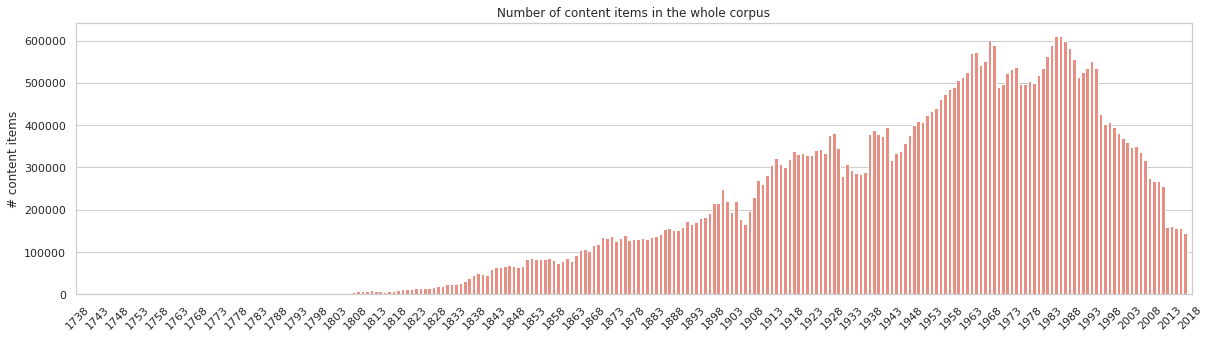

In [185]:
f = plt.figure(figsize=(20,5))

import numpy as np

#ax = plt.gca()

max_value = per_year.year.max()
min_value = per_year.year.min()
number_of_steps = 5
l = np.arange(min_value, max_value+1, number_of_steps)

g = sns.barplot(x='year',  y="count", data=per_year, color='salmon')

pos = (l - min(l)) / (max(l)-min(l))* (max(g.get_xticks())-min(g.get_xticks()))
g.set_xticks(pos);
g.set_xticklabels(l, rotation=45);
g.set_xlabel('');
g.set_ylabel('# content items');
g.set_title('Number of content items in the whole corpus');

In [ ]:
f = plt.figure(figsize=(20,5))

g = sns.barplot(x='year',  y="count", data=per_year, color='salmon')

grouping_col='year'

num_xlabels = len(per_year[grouping_col])
number_of_steps = num_xlabels/50

l = np.arange(0, num_xlabels+1, number_of_steps)

#pos = (l - min(l)) / (max(l)-min(l))* (max(g.get_xticks())-min(g.get_xticks()))
pos = (l / num_xlabels) * (max(g.get_xticks())-min(g.get_xticks()))
g.set_xticks(pos);
g.set_xticklabels(count_df[grouping_col][l], rotation=45);

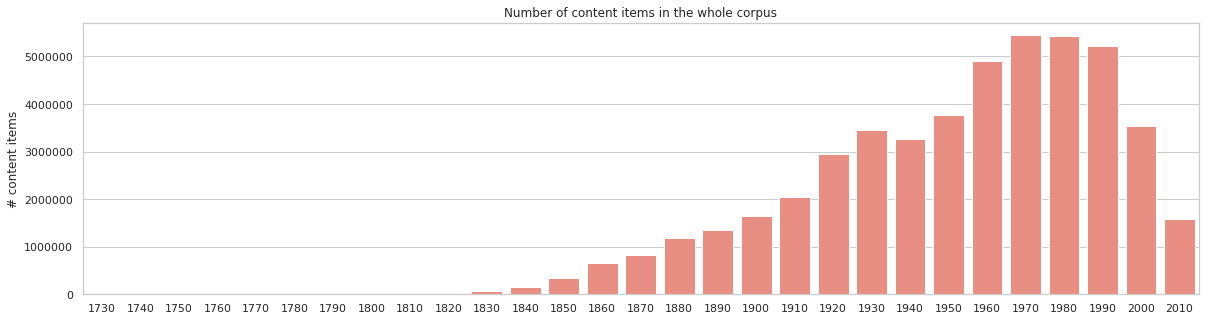

In [187]:
plt.figure(figsize=(20,5))
g=sns.barplot(x='decade', y="count", data=per_decade, color='salmon');
g.set_xlabel('');
g.set_ylabel('# content items');
g.set_title('Number of content items in the whole corpus');

In [94]:
def plot_content_item(ddf: dask.dataframe.core.DataFrame,
                        time_gran: str,
                        aggr: bool = False,
                        start_date: int = None,
                        end_date: int = None,
                        np_ids: Iterable = None,
                        country: str = None,
                        ppty: str = None,
                        ppty_value: str = None,
                        batch_size: int = None) -> None:
    """
    General plotting function for issues frequency analysis (histogram).
    :param time_gran: granularity in time, either 'year' or 'decade'
    :param start_date: earliest date for analysis
    :param end_date: latests date for analysis
    :param np_ids: list (or pandas series) of newspapers ids on which to focus
    :param country: selected country code
    :param df: original data frame on which to build the histogram
    :param ppty: selected property on which to filter newspapers
    :param ppty_value: property value corresponding to the selected property
    :param batch_size: maximum number of newspapers represented on a single plot
    :return: Nothing, but plots the histogram(s) of issue frequency.
    """
    content_df = df

    content_df, np_ids_filtered = filter_df(content_df, start_date, end_date, np_ids, country, ppty, ppty_value)

    # check time_granularity is either 'year' or 'decade'
    assert (time_gran == 'decade' or time_gran == 'year'), "Time granularity must be either 'decade' or 'year'."

    # create it decade column if doesn't exist yet
    if time_gran == 'decade' and 'decade' not in df.columns:
        content_df = decade_from_year_df(content_df, dask_df=True)

    # group and count for the histogram
    #count_df, _, _ = group_and_count(issues_df, ['newspaper_id', time_gran], 'id', print_=False)
    if aggr:
        count_df = content_df.groupby([time_gran]).id.count().compute.reset_index(name='count').sort_values(by=time_gran, inplace=True)
    else:
        count_df = content_df.groupby([time_gran, 'newspaper_id']).id.count().compute.reset_index(name='count').sort_values(by=time_gran, inplace=True)

    # if batch_size not specified : plot all newspapers on the same figure
    if batch_size is None:
        if aggr:
            g = sns.barplot(x=time_gran, y="count", data=count_df, height=5, aspect=2)
            #display_setup(g, display_x_label=False, y_label='Number of content items',
                              title='Content item frequency through time.')
        else:
            g = sns.catplot(x=time_gran, y="count", hue="newspaper_id", kind="bar", data=count_df, height=5, aspect=2)
            #display_setup(g, display_x_label=False, y_label='Number of content_items',
             #                 title='Content item frequency per newspaper, through time.')

    # else plot by batches (no intelligent batching is done)
    #else:
     #   assert (0 < batch_size and batch_size < 20), "Batch size must be between 1 and 19."
      #  catplot_by_batch_np(count_df, np_ids_filtered, 'decade', 'count', 'newspaper_id', batch_size,
       #                     display_x_label=False, y_label='Number of issues',
        #                    title='Issue frequency per newspaper, through time.')

### Number of content items per np

In [211]:
count_rows_np = test_df.groupby('newspaper').id.count()

In [212]:
%%time 
count_rows_np_pd = count_rows_np.compute()

CPU times: user 3min 55s, sys: 23.6 s, total: 4min 18s
Wall time: 3min 7s


In [213]:
count_rows_np_pd = count_rows_np_pd.reset_index(name='ci_count')

In [214]:
count_rows_np_pd.sort_values(by='ci_count', inplace=True, ascending=False)

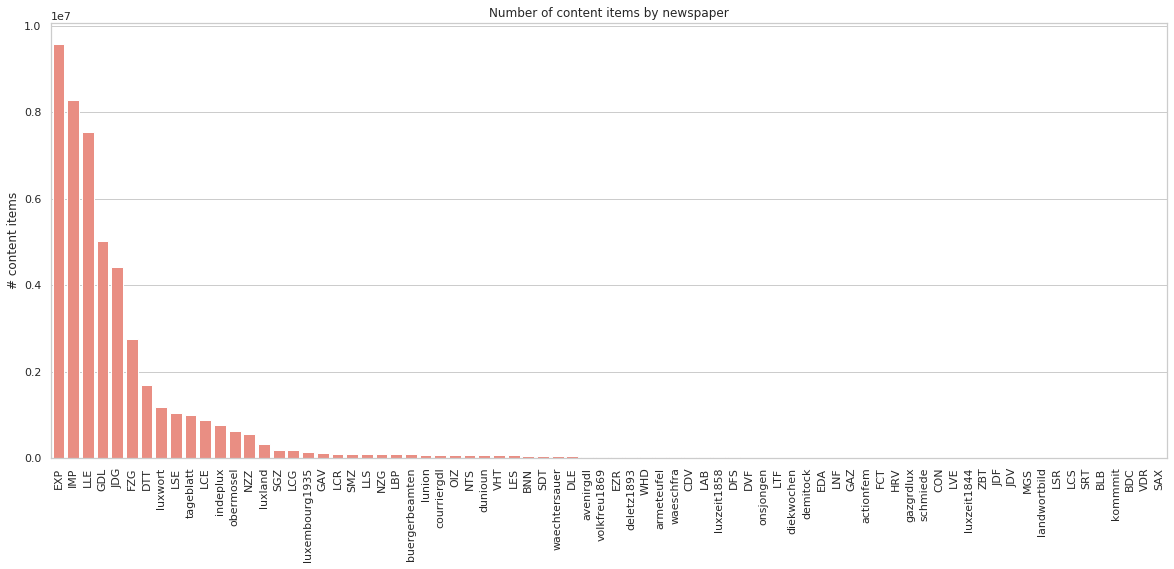

In [219]:
plt.figure(figsize=(20,8))

g=sns.barplot(x='newspaper', y="ci_count", data=count_rows_np_pd, color='salmon');

g.set_xticklabels(count_rows_np_pd.newspaper, rotation=90);
g.set_xlabel('');
#g.set_yticklabels(count_rows_np_pd.ci_count);
g.set_ylabel('# content items');
g.set_title('Number of content items by newspaper');

### Number of content item per type

In [221]:
count_rows_type = test_df.groupby('type').id.count()

In [223]:
count_rows_type_pd = count_rows_type.compute()

In [224]:
count_rows_type_pd = count_rows_type_pd.reset_index(name='ci_count')

In [225]:
count_rows_type_pd.sort_values(by='ci_count', inplace=True, ascending=False)

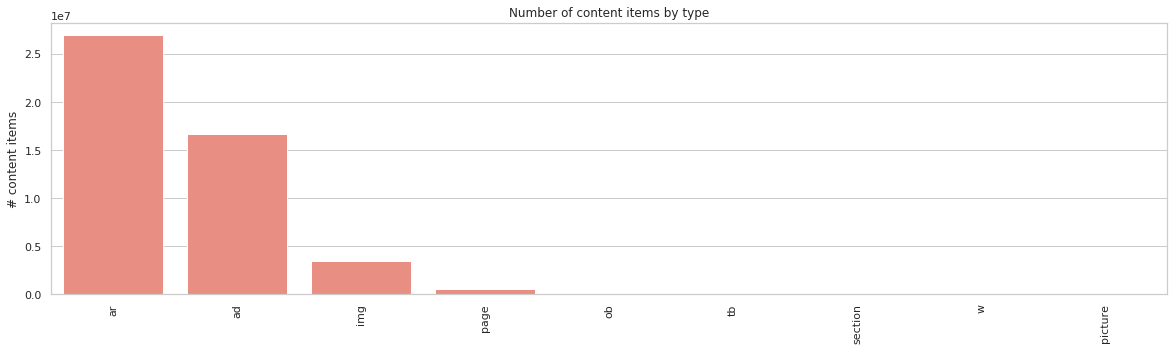

In [230]:
plt.figure(figsize=(20,5))

g=sns.barplot(x='type', y="ci_count", data=count_rows_type_pd, color='salmon');

g.set_xticklabels(count_rows_type_pd.type, rotation=90);
g.set_xlabel('');
#g.set_yticklabels(count_rows_np_pd.ci_count);
g.set_ylabel('# content items');
g.set_title('Number of content items by type');

In [241]:
len(per_year.year)/5

50.2

In [239]:
len(count_rows_type_pd.type)

9

In [ ]:
max_value = per_year.year.max()
min_value = per_year.year.min()
number_of_steps = 5
l = np.arange(min_value, max_value+1, number_of_steps)

g = sns.barplot(x='year',  y="count", data=per_year, color='salmon')

pos = (l - min(l)) / (max(l)-min(l))* (max(g.get_xticks())-min(g.get_xticks()))
g.set_xticks(pos);
g.set_xticklabels(l, rotation=45);
g.set_xlabel('');
g.set_ylabel('# content items');
g.set_title('Number of content items in the whole corpus');

In [250]:
label_threshold_rotation=30
label_threshold_select = 100

def ci_plot_1d(df, grouping_col, asc=False, no_x_title=False):
    
    # Perfom the group by and count operation and convert to pandas df
    count_df = df.groupby(grouping_col).id.count().compute().reset_index(name='ci_count')
    
    # Sort by count descending (default), or other if specified (time / ascending)
    if grouping_col in ['year', 'decade'] :
        count_df.sort_values(by=grouping_col, inplace=True, ascending=False)
    else:
        count_df.sort_values(by='ci_count', inplace=True, ascending=asc)
    
    num_xlabels = len(count_df[grouping_col])
    
    # Plot figure
    plt.figure(figsize=(20,5))

    g=sns.barplot(x=grouping_col, y="ci_count", data=count_df, color='salmon');

    # Set x axis labels
    # no particular setup if number of labels is less than the first threshold
    if num_xlabels < label_threshold_rotation:
        g.set_xticklabels(count_df[grouping_col])
        
    # rotate by 90 degrees if number of labels is between first and second threshold
    elif num_xlabels <  label_threshold_select:
        g.set_xticklabels(count_df[grouping_col], rotation=90)
       
    # display only certain labels (and rotate by 45 degrees) if number of labels is higher
    else :        
        number_of_steps = num_xlabels/50
        
        l = np.arange(0, num_xlabels+1, number_of_steps)
        
        #pos = (l - min(l)) / (max(l)-min(l))* (max(g.get_xticks())-min(g.get_xticks()))
        pos = (l / num_xlabels) * (max(g.get_xticks())-min(g.get_xticks()))
        g.set_xticks(pos);
        g.set_xticklabels(count_df[grouping_col][l], rotation=45);
     
    # option to remove the x axis title (when its obvious, e.g. for the years)
    if no_x_title:
        g.set_xlabel('');
    else:
        g.set_xlabel(grouping_col);
        
    #g.set_yticklabels(count_rows_np_pd.ci_count);
    g.set_ylabel('# content items');
    g.set_title('Number of content items by %s' % grouping_col);

#### Plotting fonction for the content item frequency, aggregated at one level
- type
- year
- decade
- newspaper

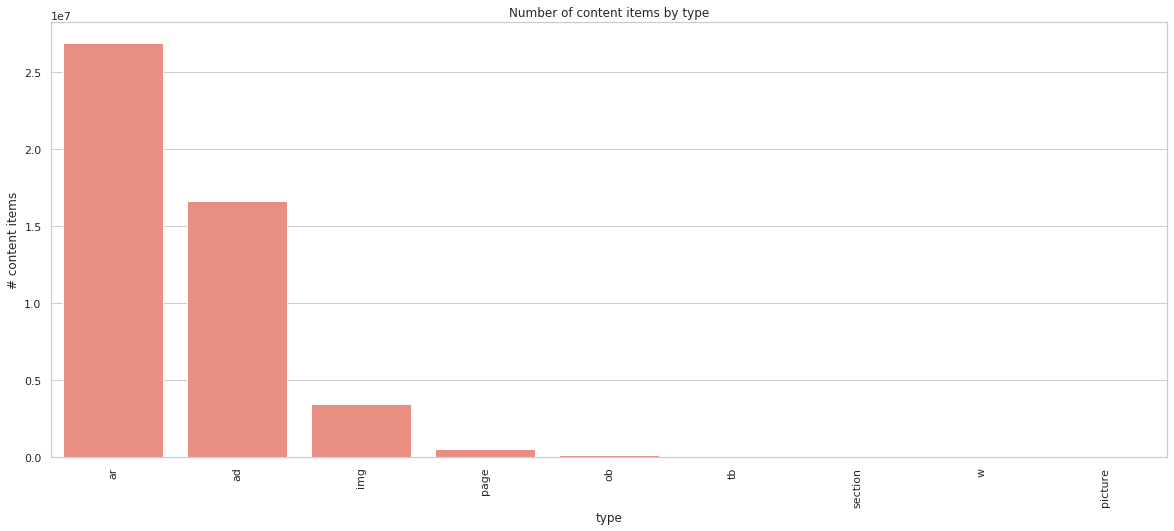

In [236]:
#Type
ci_plot_1d(test_df, 'type')

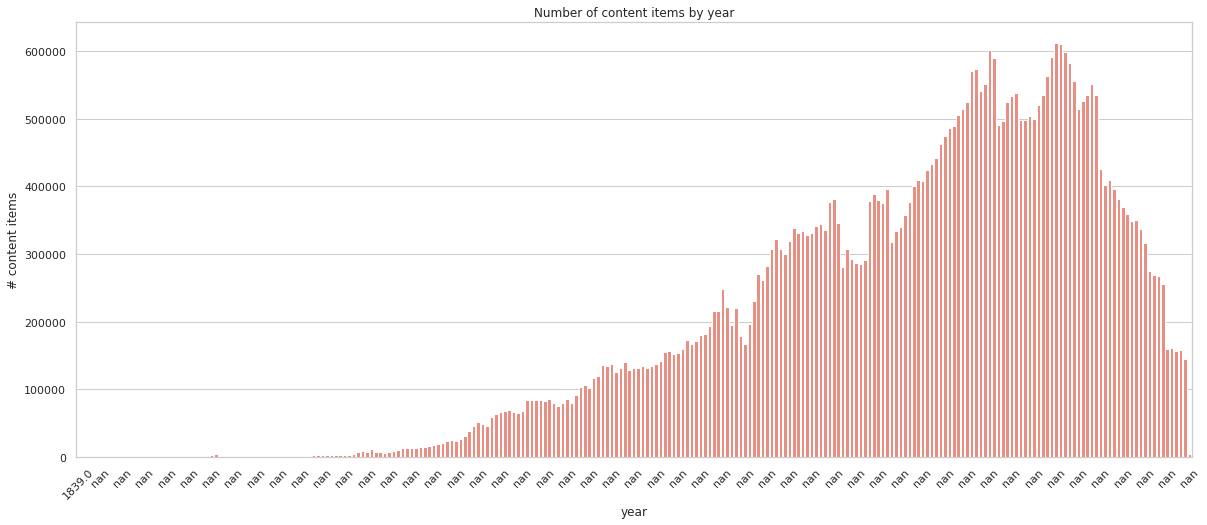

In [248]:
#Year
ci_plot_1d(test_df, 'year')

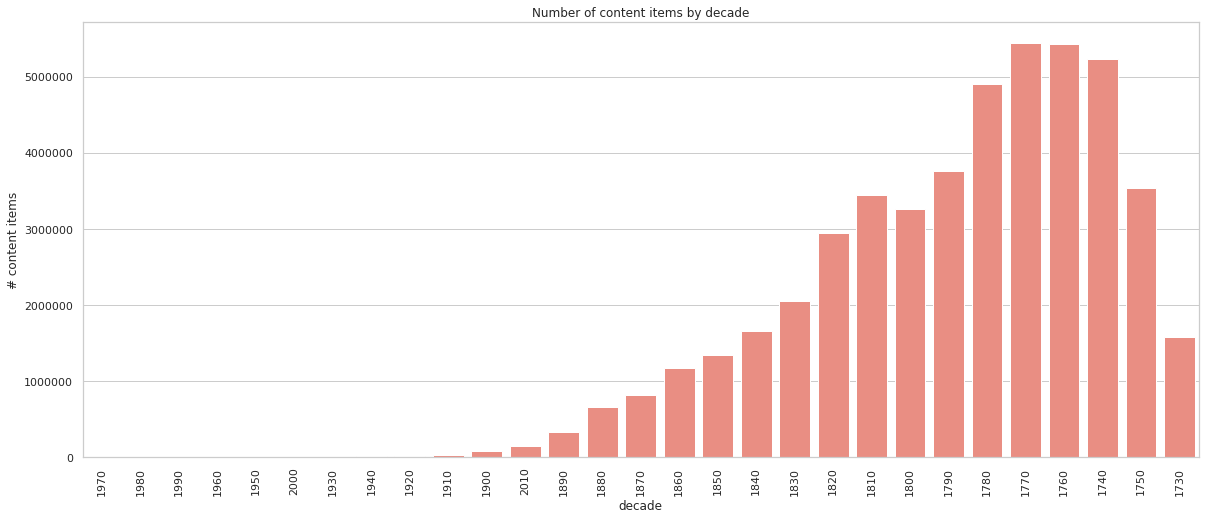

In [238]:
#Decade
ci_plot_1d(test_df, 'decade')

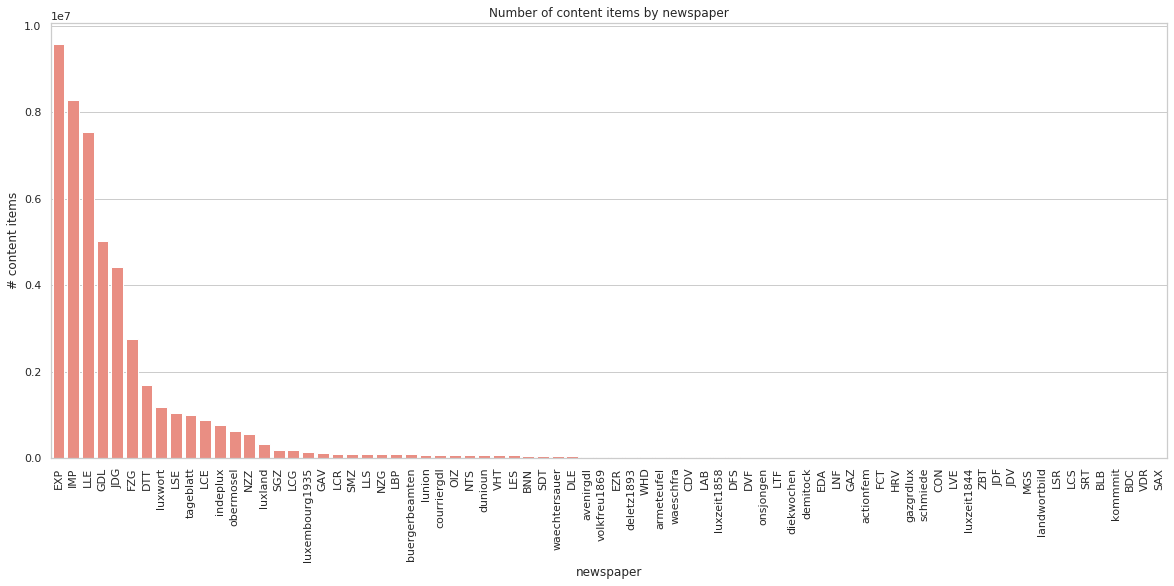

In [235]:
#Newspaper
ci_plot_1d(test_df, 'newspaper')

#TODO : logarithmis scale (pass as parameter)

### Join with issues table (for licenses)

#### Create column issue id

In [191]:
# Extract issue_id from content item id
test_df['issue_id'] = test_df.id.apply(lambda x: x[:x.rfind("-")], meta=str)

In [192]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id,decade
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a,1830
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a,1830
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a,1830
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a,1830
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a,1830


#### Join with issues table

In [193]:
from sql import db_engine, read_table

In [194]:
engine = db_engine()
issues_df = read_table('impresso.issues', engine)
issues_df = issues_df.rename(columns={"id": "issue_id"})

In [23]:
issues_df.head()

,issue_id,year,month,day,edition,access_rights,created,last_modified,is_damaged,s3_version,newspaper_id
0,actionfem-1927-10-15-a,1927,10,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
1,actionfem-1927-11-15-a,1927,11,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
2,actionfem-1927-12-15-a,1927,12,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
3,actionfem-1928-01-15-a,1928,1,15,a,Closed,2019-06-15 12:22:41,NaT,0,,actionfem
4,actionfem-1928-02-15-a,1928,2,15,a,Closed,2019-06-15 12:22:41,NaT,0,,actionfem


In [24]:
ar_content_item = test_df.merge(issues_df, on='issue_id', suffixes=('_ci', '_issue'))

In [25]:
ar_content_item.head(3)

,id,year_ci,newspaper,type,n_tokens,title_length,issue_id,year_issue,month,day,edition,access_rights,created,last_modified,is_damaged,s3_version,newspaper_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a,1839,1,20,a,OpenPublic,2019-06-17 11:53:25,NaT,0,,BDC
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a,1839,1,20,a,OpenPublic,2019-06-17 11:53:25,NaT,0,,BDC
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a,1839,1,20,a,OpenPublic,2019-06-17 11:53:25,NaT,0,,BDC


#### Clean & keep only useful columns

In [26]:
ar_content_item = ar_content_item[['id', 'newspaper_id', 'type', 'n_tokens', 'year_issue', 'month', 'day', \
                                   'access_rights']].rename(columns={'year_issue':'year'})

In [27]:
ar_content_item.head()

,id,newspaper_id,type,n_tokens,year,month,day,access_rights
0,BDC-1839-01-20-a-i0001,BDC,ar,250.0,1839,1,20,OpenPublic
1,BDC-1839-01-20-a-i0002,BDC,ar,758.0,1839,1,20,OpenPublic
2,BDC-1839-01-20-a-i0003,BDC,ar,14.0,1839,1,20,OpenPublic
3,BDC-1839-01-20-a-i0004,BDC,ar,349.0,1839,1,20,OpenPublic
4,BDC-1839-01-20-a-i0005,BDC,ar,193.0,1839,1,20,OpenPublic


In [30]:
%time ar_content_item.shape[0].compute()

CPU times: user 5min 39s, sys: 37.9 s, total: 6min 17s
Wall time: 4min 22s


33707113

#### Number of content-item per access right

In [60]:
%%time
ar_per_CI = ar_content_item[['id', 'access_rights']].groupby('access_rights').id.count().compute()

CPU times: user 5min 47s, sys: 34.7 s, total: 6min 22s
Wall time: 4min 24s


In [61]:
ar_per_CI

access_rights
OpenPublic      1427254
OpenPrivate    29158736
Closed          3121123
Name: id, dtype: int64

## Filter content item dataframe

### Test filter function with several parameters on dask df

In [62]:
from helpers import filter_df

In [63]:
ar_content_item_sub,_ = filter_df(ar_content_item, np_ids=['GDL', 'NZZ', 'JDG'], start_date=1780, end_date=1810)

Following cell takes 7min to run : outputs 24'294 >> can be converted to pandas df

In [ ]:
%time ar_content_item_sub.shape[0].compute()

In [ ]:
ar_content_item_sub_pd = ar_content_item_sub.compute()

In [ ]:
ar_content_item_sub_pd

In [ ]:
from visualization import plot_licences

In [ ]:
plot_licences(facet='time', df=ar_content_item_sub_pd)

In [ ]:
plot_licences(facet='newspapers', df=ar_content_item_sub_pd)

In [ ]:
import pandas
from typing import Iterable

In [ ]:
## TODO : FINISH THIS
def plot_licences_content_it(
    facet: str = 'newspapers',
    ddf: pandas.core.frame.DataFrame = None,
    start_date: int = None,
    end_date: int = None,
    np_ids: Iterable = None,
    country: str = None,
    batch_size: int = None,
    ppty: str = None,
    ppty_value: str = None,
) :
    
    ddf_sub,_ = filter_df(ddf, start_date, end_date, np_ids, country, ppty, ppty_value)
    #TODO : add condition on the size of teh df before calling compute()
    df = ddf_sub.compute()
    plot_licences(facet=facet, df=df)
    

## Others

In [ ]:
def np_pd(ddf, npID: str, max_rows: int):
    if len(ddf.loc[ddf.newspaper == npID] < max_rows) :
        return ddf.loc[ddf.newspaper == npID].compute()
    else :
        print('Length of dataframe exceeds max_rows > cannot be converted to pandas df.')
        return None

In [ ]:
def num_content_items(npID: str):
    return test_df.loc[test_df.newspaper == npID].count().compute()

In [37]:
def num_content_items2(npID: str):
    return test_df.filter(test_df.newspaper == npID).count().compute()

In [38]:
%time num_content_items2('BDC')

AttributeError: 'DataFrame' object has no attribute 'filter'

In [49]:
%time num_content_items('BLB')

CPU times: user 3min 23s, sys: 6min 52s, total: 10min 15s
Wall time: 1min 2s


id              429
year            429
newspaper       429
type            429
n_tokens        429
title_length    429
dtype: int64

In [26]:
%time test_df.loc[test_df.newspaper == 'BDC'].compute()

CPU times: user 3min 24s, sys: 6min 44s, total: 10min 9s
Wall time: 1min 1s


,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN
...,...,...,...,...,...,...
7,BDC-1839-04-04-a-i0002,1839,BDC,ar,713.0,NaN
8,BDC-1839-04-04-a-i0003,1839,BDC,ar,773.0,NaN
9,BDC-1839-04-04-a-i0004,1839,BDC,ar,396.0,NaN
10,BDC-1839-04-04-a-i0005,1839,BDC,ar,336.0,NaN
